# Données du projet

Nous allons découvrir dans ce TP les [données utilisées](https://opendata.paris.fr/explore/dataset/horodateurs-transactions-de-paiement/) dans le projet à rendre, qui sont l'ensemble des **transactions sur les horodateurs dans la ville de Paris** sur l'année 2014. Celles-ci proviennent du site [Open Data Paris](https://opendata.paris.fr), répertoire des données ouvertes de la ville de Paris. Elles sont stockées sur le serveur *MongoDB* déjà utilisé, dans la base `horodateurs`.

Elle contient deux collections principales :

- `transactions` : ensemble des paiements
- `mobiliers`: liste de tous les horodateurs


In [1]:
import pymongo
import pandas
from pprint import pprint

con = pymongo.MongoClient("mongodb://193.51.82.104:2343/")

horo = con.horodateurs
horo.list_collection_names()

['transactions_small', 'myresults', 'transactions', 'mobiliers']

## Taille des données

Il y a un grand nombre de transactions stockées dans la base (plus de 24 millions - cf ci-dessous).

In [2]:
horo.transactions.estimated_document_count() # estimation du dénombrement (pas exacte mais bcp plus rapide)

24448030

Nous disposons d'un échantillon réduit de transactions (1%) permettant de tester rapidement le code qu'on souhaite exécuter (plutôt que de lancer un code erroné ou trop lourd sur l'ensemble des données).

In [3]:
horo.transactions_small.count_documents({}) # anciennement count()

244480

Nous disposons aussi de la liste des mobiliers, c'est-à-dire des horodateurs de la ville de Paris.

In [4]:
horo.mobiliers.count_documents({})

7810

Pour avoir une estimation de la taille des données, nous récupérons l'ensemble des transactions de l'échantillon réduit dans un `DataFrame`.

In [ ]:
trans_small = pandas.DataFrame(list(horo.transactions_small.find()))

Il est maintenant possible de connaître la taille des données grâce à l'objet `values.nbytes` du `DataFrame` créé.

In [6]:
print(trans_small.values.nbytes)

17602560


L'objet finalement obtenu a donc une taille de presque 17 Mo (cf calcul ci-dessous).

In [7]:
trans_small.values.nbytes / (1024 * 1024) # En Mo

16.787109375

Une rapide estimation pour la totalité (grâce à une règle de trois) nous permet de voir que l'objet final contenant les transactions sur toute l'année (sans pré-calcul dans *MongoDB*) aurait une taille de plus de 1.6 Go. Il va donc falloir faire attention aux calculs que l'on va lancer, et aux choix de récupération de données qu'on va faire.

In [8]:
trans_small.values.nbytes / (1024 ** 3) * (horo.transactions.estimated_document_count() / horo.transactions_small.estimated_document_count())

1.639368161559105

## Contenu des données

Afin de mieux comprendre les données, nous affichons le premier document de chaque collection.

Pour les transactions, nous avons les informations présentées dans le fichier PDF joint avec les données (cf lien au début du TP). On a en particulier le numéro de l'horodateur dans l'item `horodateur`. Celui-ci nous permettra de faire le lien avec l'autre collection.

In [9]:
pprint(horo.transactions.find_one())

{'_id': ObjectId('56eaa8279fae0d71f77ea2bd'),
 'date horodateur': datetime.datetime(2014, 1, 9, 14, 9, 47),
 'durée payée (h)': 0.5,
 'début stationnement': datetime.datetime(2014, 1, 9, 14, 9, 47),
 'fin stationnement': datetime.datetime(2014, 1, 9, 14, 39, 47),
 'horodateur': 1050,
 'montant carte': 1.8,
 'moyen de paiement': 'Paris Carte',
 'usager': 'Rotatif'}


Dans la collection `mobiliers`, nous avons plusieurs informations (à voir aussi dans le PD joint sur [cette page](https://opendata.paris.fr/explore/dataset/horodateurs-mobiliers/information/)). On dispose bien évidemment du numéro d'horodateurs (avec l'attribut `numhoro`), mais aussi de la localisation géographique de l'horodateur (sous différents formats, permettant leur utilisation de plusieurs façons).

In [10]:
pprint(horo.mobiliers.find_one())

{'_id': ObjectId('56eaa4552d7eb34e4432e0fb'),
 'datasetid': 'horodateurs-mobiliers',
 'fields': {'adresse': '48 vis-à-vis RUE DE LISBONNE',
            'alim': 'SOLAIRE',
            'arrondt': 8,
            'geo_point_2d': [48.877489999731374, 2.311394999713242],
            'geo_shape': {'coordinates': [2.311394999713242,
                                          48.877489999731374],
                          'type': 'Point'},
            'modele': 'SAB3',
            'numhoro': 57080603,
            'objectid': 4383,
            'regime': 'MIX',
            'tarif': '4,00 E MIX 2U',
            'tarifhor': 4.0,
            'zoneres': '8J'},
 'geometry': {'coordinates': [2.311394999713242, 48.877489999731374],
              'type': 'Point'},
 'record_timestamp': '2015-12-02T17:49:46+00:00',
 'recordid': '698c75a21ba4f4c34e72f32ea1ecd94f9de8b88c'}


## A Faire

Cette première partie à faire vous permettra de vous familariser avec les données.

### Mobiliers

1. Donner les différents types d'alimentation possible (`alim`) et le nombre d'horodateurs pour chaque. 
1. Donner le nombre de mobiliers pour chaque arrondissement (`arrondt`)
1. Lister l'ensemble des modèles existants (`modele`)
1. Croiser le régime (`regime`) et les arrondissements pour voir s'il y a des différences notables
1. Idem avec le tarif horaire (`tarifhor`)

### Transactions

1. Donner la distribution des montants payés (`montant carte`) et des durées payées (`durée payée (h)`)
1. Lister les différents moyens de paiements utilisés (`moyen de paiement`) et le type d'usager (`usager`), en ordonnant chaque table résultat par ordre décroissant du nombre de paiements
1. Déterminer s'il existe un lien entre le moyen de paiement, et le montant d'une part et la durée d'autre part

In [4]:
import pymongo
import pandas
from pprint import pprint
import seaborn
%matplotlib inline

### **Mobiliers**

- Donner les différents types d'alimentation possible (`alim`) et le nombre d'horodateurs pour chaque. 

In [11]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.alim", "nb" : { "$sum" : 1}}}
]))
pprint(res)

[{'_id': None, 'nb': 8},
 {'_id': 'PILE', 'nb': 2994},
 {'_id': 'SOLAIRE', 'nb': 4808}]


In [12]:
df = pandas.DataFrame(res) 
df.columns = ["Alimentation", "Effectif"]
df

,Alimentation,Effectif
0,None,8
1,PILE,2994
2,SOLAIRE,4808


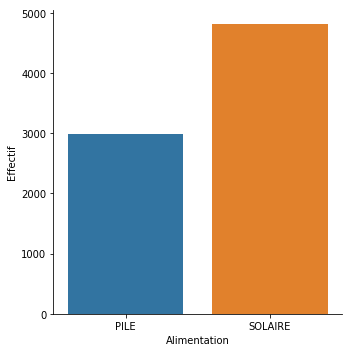

In [16]:
seaborn.catplot(x = "Alimentation", y = "Effectif", data = df, kind = "bar")

- Donner le nombre de mobiliers pour chaque arrondissement (arrondt)

In [59]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1}}},
    { "$sort" : { "_id": 1}}
]))

In [60]:
df = pandas.DataFrame(res) 
df.columns = ["Arrondissement", "Effectif"]

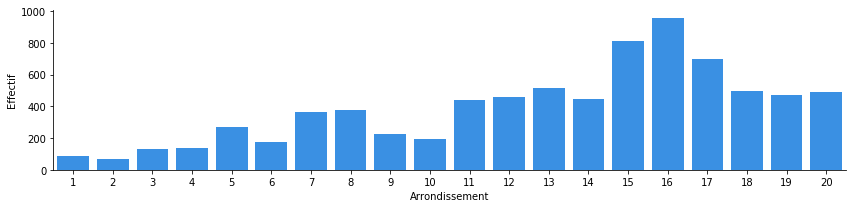

In [80]:
seaborn.catplot(x = "Arrondissement", y = "Effectif", color = 'dodgerblue',
                   data = df, kind = "bar", height = 3, aspect = 4)

- Lister l'ensemble des modèles existants (modele)

In [83]:
horo.mobiliers.distinct("fields.modele")

['SAB3', 'SMB2', 'MUI']

In [84]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.modele", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb": -1}}
]))

In [85]:
df = pandas.DataFrame(res) 
df.columns = ["Modèle", "Effectif"]

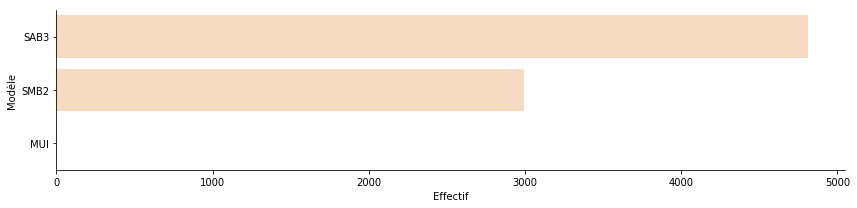

In [87]:
seaborn.catplot(y = "Modèle", x = "Effectif", color = "peachpuff",
                   data = df, kind = "bar", height = 3, aspect = 4)

- Croiser le régime (regime) et les arrondissements pour voir s'il y a des différences notables

In [2]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : { "reg" : "$fields.regime", "arr" : "$fields.arrondt"}, "nb" : { "$sum" : 1}}},
    { "$project": { "regime" : "$_id.reg", "arrondissement" : "$_id.arr", "effectif" : "$nb" }},
    { "$sort" : { "arrondissement" : 1}}
]))
df = pandas.DataFrame(res).drop("_id", 1)
df.head()

,arrondissement,effectif,regime
0,1,24,ROT
1,1,63,MIX
2,2,18,ROT
3,2,49,MIX
4,3,82,MIX


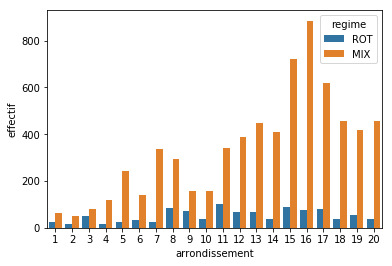

In [9]:
seaborn.barplot(x = "arrondissement", y = "effectif", hue = "regime", data = df)

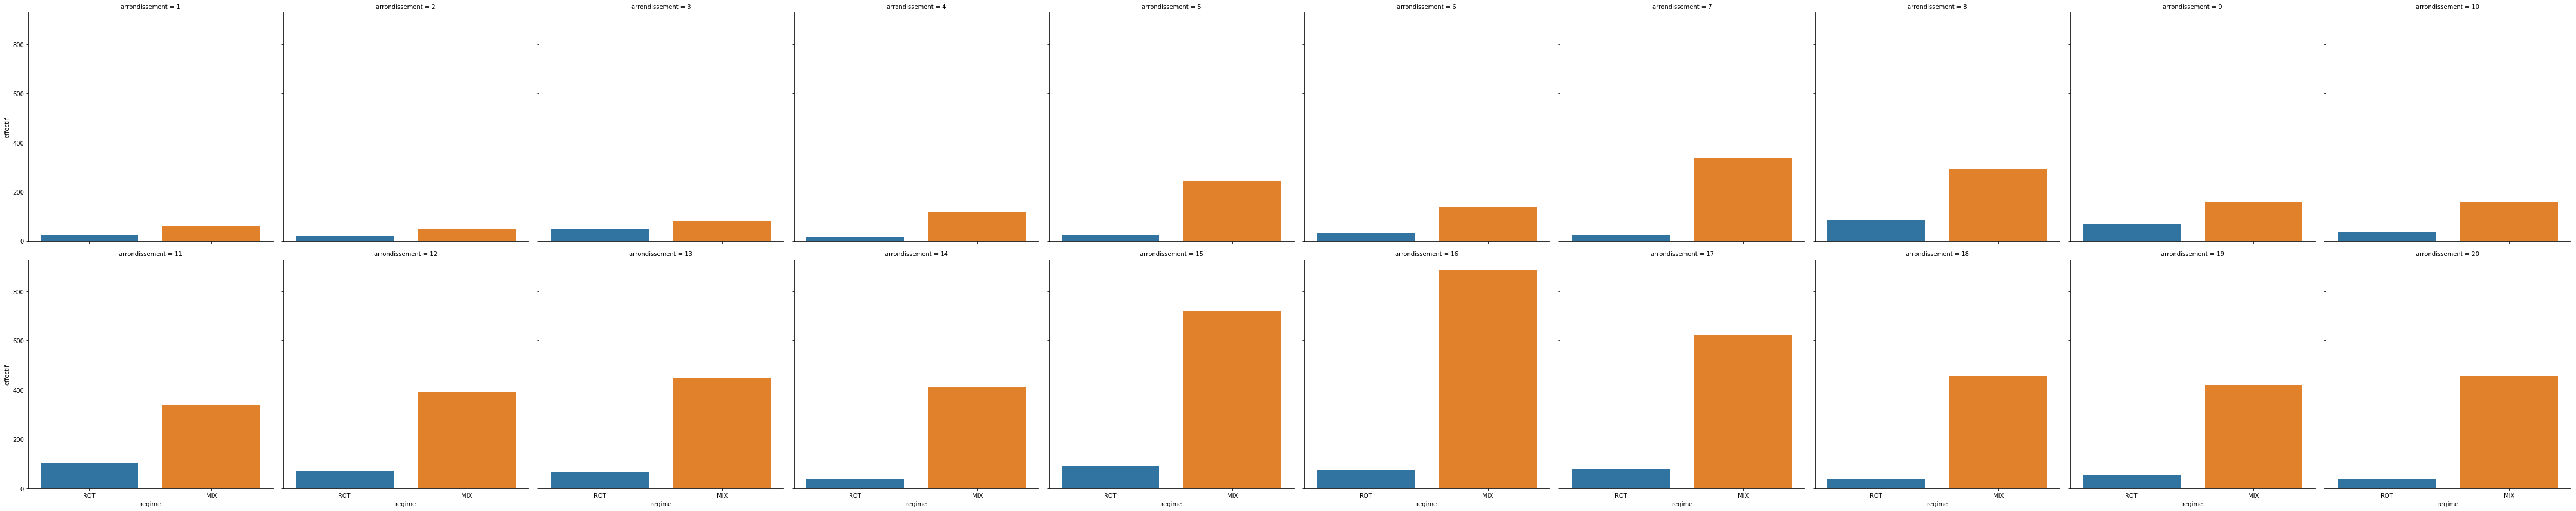

In [36]:
seaborn.catplot(x = "regime", y = "effectif",
                   col = "arrondissement", col_wrap = 10,
                   data = df, kind = "bar", height = 6)

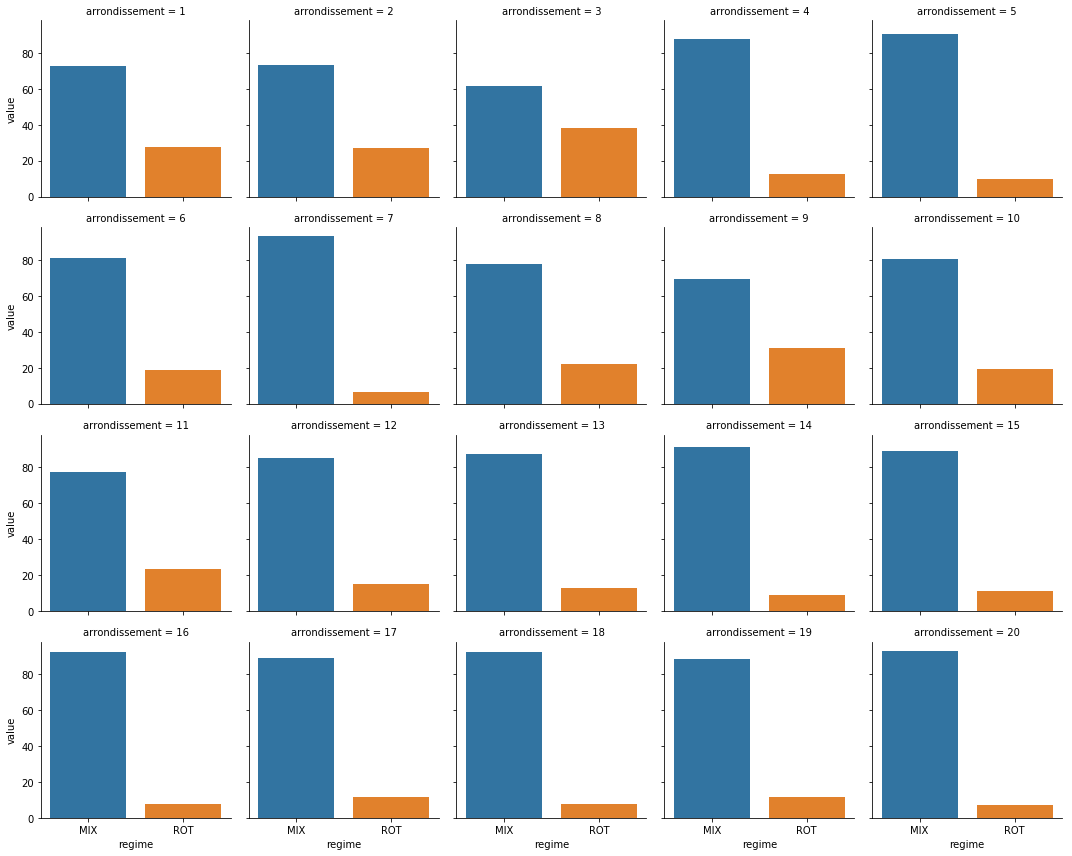

In [38]:
t = pandas.crosstab(df.regime, df.arrondissement, df.effectif, normalize = "columns", aggfunc = sum)
t = t.assign(regime = t.index)
tm = pandas.melt(t, id_vars = "regime")
tm = tm.assign(value = 100 * tm.value)

seaborn.catplot(x = "regime", y = "value", 
                   col = "arrondissement", col_wrap = 5, 
                   data = tm, kind = "bar", height = 3)

- Idem avec le tarif horaire (tarifhor)

In [10]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : { "reg" : "$fields.tarifhor", "arr" : "$fields.arrondt"}, "nb" : { "$sum" : 1}}},
    { "$project": { "tarif" : "$_id.reg", "arrondissement" : "$_id.arr", "effectif" : "$nb" }},
    { "$sort" : { "arrondissement" : 1}}
]))
df = pandas.DataFrame(res).drop("_id", 1)
df.head()

,arrondissement,effectif,tarif
0,1,87,4.0
1,2,67,4.0
2,3,133,4.0
3,4,135,4.0
4,5,267,4.0


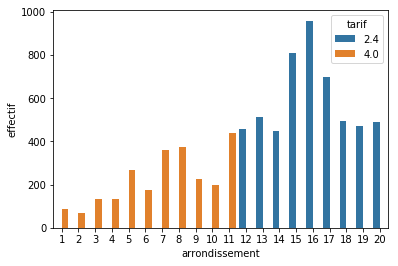

In [11]:
seaborn.barplot(x = "arrondissement", y = "effectif", hue = "tarif", data = df)

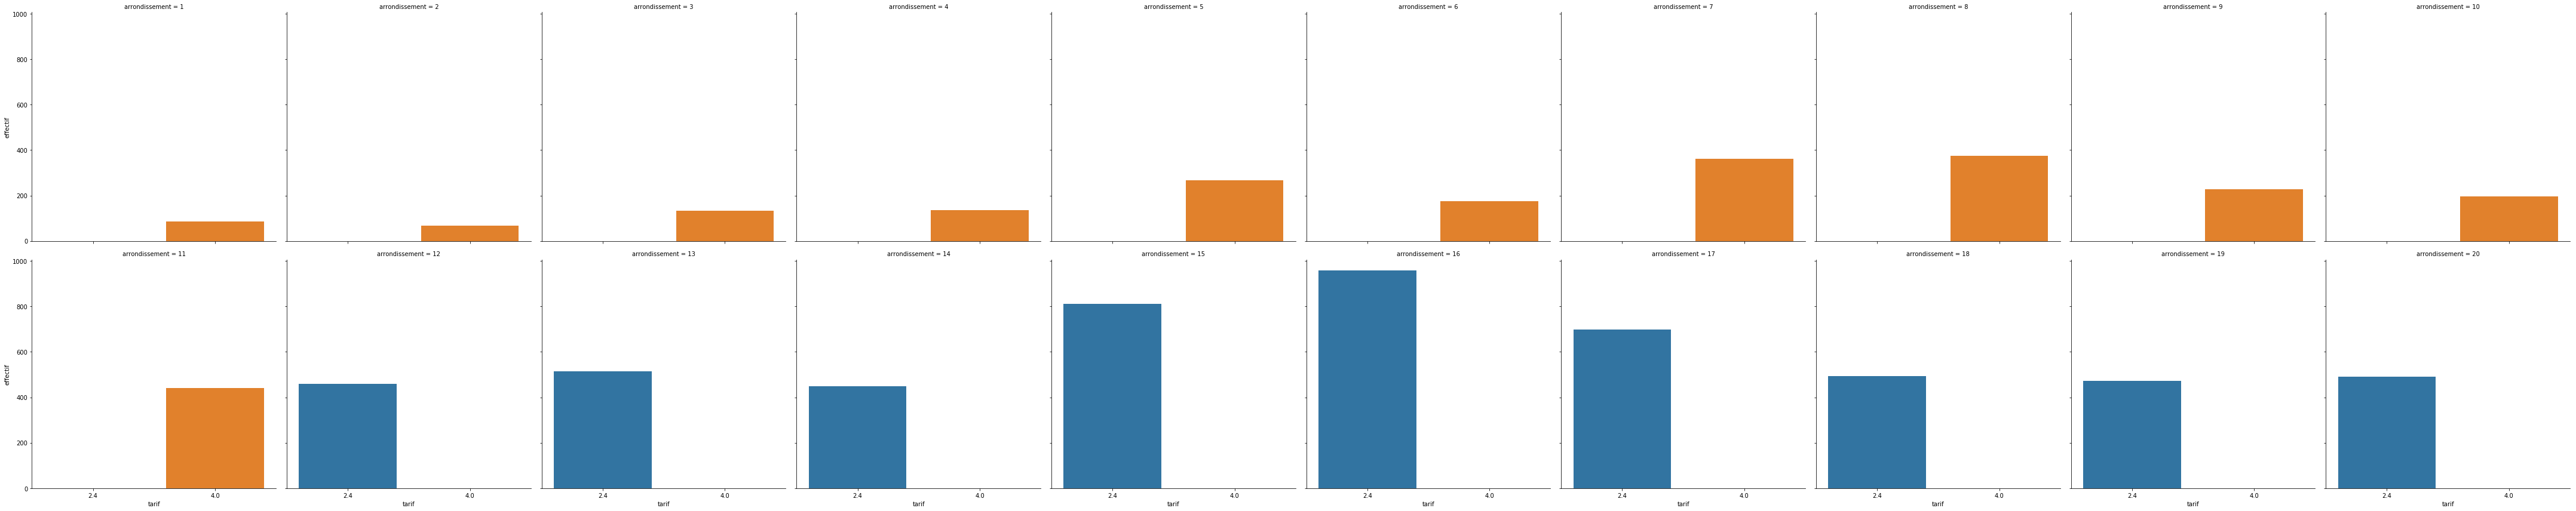

In [43]:
seaborn.catplot(x = "tarif", y = "effectif",
                   col = "arrondissement", col_wrap = 10,
                   data = df, kind = "bar", height = 6)

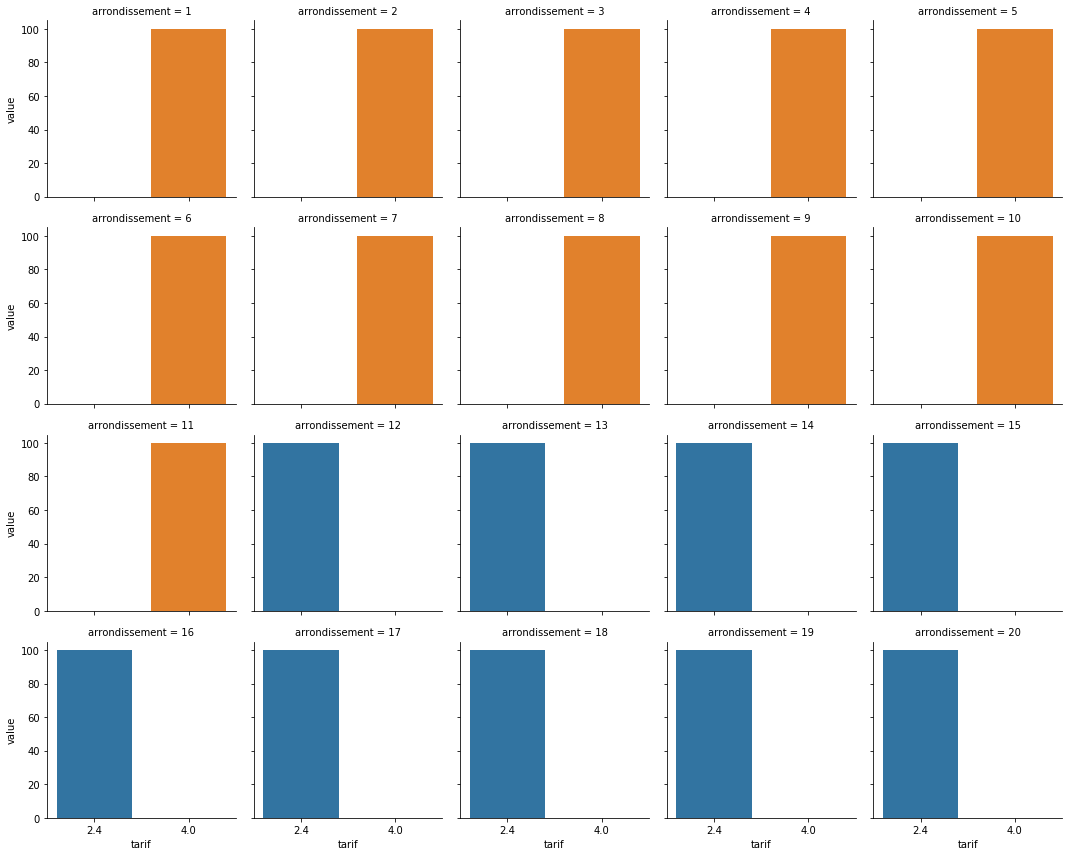

In [46]:
t = pandas.crosstab(df.tarif, df.arrondissement, df.effectif, normalize = "columns", aggfunc = sum)
t = t.assign(tarif = t.index)
tm = pandas.melt(t, id_vars = "tarif")
tm = tm.assign(value = 100 * tm.value)

seaborn.catplot(x = "tarif", y = "value", 
                   col = "arrondissement", col_wrap = 5, 
                   data = tm, kind = "bar", height = 3)

### **Transactions**

- Donner la distribution des montants payés (montant carte) et des durées payées (durée payée (h))

In [12]:
res = list(horo.transactions_small.find({}, {"_id": 0, "montant carte" : 1}))

In [48]:
df = pandas.DataFrame(res)

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


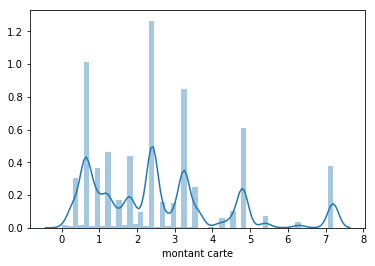

In [49]:
seaborn.distplot(df["montant carte"])

In [16]:
res = list(horo.transactions_small.find({}, {"_id": 0, "durée payée (h)" : 1}))

In [17]:
df = pandas.DataFrame(res)

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


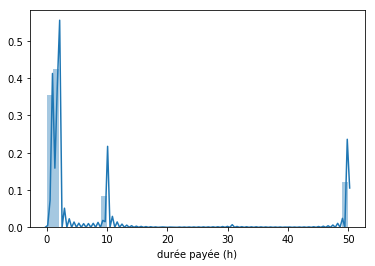

In [18]:
seaborn.distplot(df["durée payée (h)"])

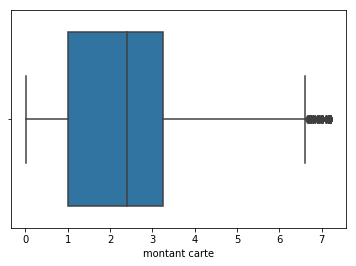

In [50]:
seaborn.boxplot(x = "montant carte", data = df)

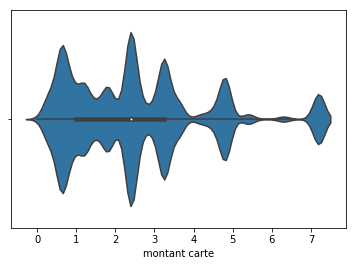

In [52]:
seaborn.violinplot(x = "montant carte", data = df)

- Lister les différents moyens de paiements utilisés (moyen de paiement) et le type d'usager (usager), en ordonnant chaque table résultat par ordre décroissant du nombre de paiements

In [53]:
res = list(horo.transactions.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb" : -1 }}
]))
pprint(pandas.DataFrame(res))

           _id        nb
0  Paris Carte  13181015
1           CB  11267015


In [54]:
res = list(horo.transactions.aggregate([
    { "$group" : { "_id" : "$usager", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb" : -1 }}
]))
pprint(pandas.DataFrame(res))

        _id        nb
0   Rotatif  19033897
1  Résident   5414133


- Déterminer s'il existe un lien entre le moyen de paiement, et le montant d'une part et la durée d'autre part

In [55]:
res = list(horo.transactions_small.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "montant" : { "$avg" : "$montant carte"}}},
    { "$sort" : { "nb" : -1 }}
]))
pprint(pandas.DataFrame(res))

           _id   montant
0           CB  3.007229
1  Paris Carte  2.161537


In [56]:
res = list(horo.transactions_small.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "durée" : { "$avg" : "$durée payée (h)"}}},
    { "$sort" : { "nb" : -1 }}
]))
pprint(pandas.DataFrame(res))

           _id     durée
0           CB  8.254365
1  Paris Carte  8.261151


## Autre version

### Mobiliers

In [20]:
# Donner les différents types d'alimentation possible (alim) et le nombre d'horodateurs pour chaque.
horo.mobiliers.distinct("fields.alim")

pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$group": { "_id": "$fields.alim", "Nb": { "$sum": 1 }}}
])))


,Nb,_id
0,8,None
1,2994,PILE
2,4808,SOLAIRE


In [21]:
# Donner le nombre de mobiliers pour chaque arrondissement (arrondt)
pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$group": { "_id": "$fields.arrondt", "Nb": { "$sum": 1 }}},
    { "$sort": { "Nb": - 1 }},
    { "$project": { "Arrondissement": "$_id", "Nb": 1, "_id": 0 }}
])))

,Arrondissement,Nb
0,16,959
1,15,810
2,17,698
3,13,514
4,18,494
5,20,492
6,19,473
7,12,458
8,14,448
9,11,440


In [22]:
# Lister l'ensemble des modèles existants (modele)
horo.mobiliers.distinct("fields.modele")

['SAB3', 'SMB2', 'MUI']

In [23]:
# Croiser le régime (regime) et les arrondissements pour voir s'il y a des différences notables
tab = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$group": { "_id": { "regime": "$fields.regime", "arr": "$fields.arrondt" }, "Nb": { "$sum": 1 }}},
    { "$project": { "Arrondissement": "$_id.arr", "Regime": "$_id.regime", "Nb": 1, "_id": 0 }}
])))
tab.head()

,Arrondissement,Nb,Regime
0,1,24,ROT
1,16,74,ROT
2,7,24,ROT
3,3,82,MIX
4,5,26,ROT


In [24]:
import seaborn
%matplotlib inline

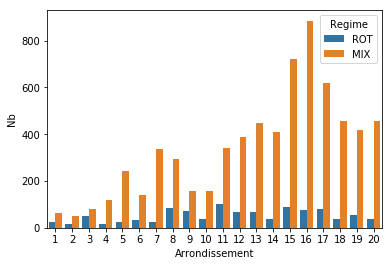

In [25]:
seaborn.barplot(x = "Arrondissement", y = "Nb", hue = "Regime", data = tab)

In [26]:
import numpy
tabbis = pandas.crosstab(tab.Arrondissement, tab.Regime, values=tab.Nb, aggfunc= numpy.sum, normalize = "index") * 100
tabbis = tabbis.assign(Arr = tabbis.index)

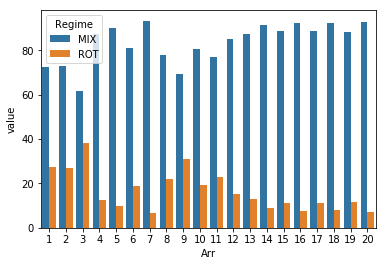

In [27]:
tabter = tabbis.melt(id_vars="Arr")
seaborn.barplot(x = "Arr", y = "value", hue = "Regime", data = tabter)

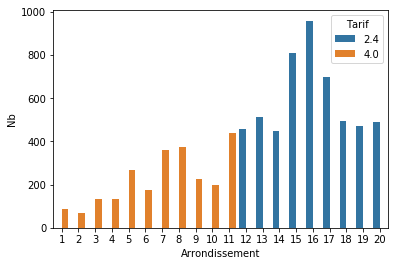

In [28]:
# Idem avec le tarif horaire (tarifhor)
tab2 = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$group": { "_id": { "tarif": "$fields.tarifhor", "arr": "$fields.arrondt" }, "Nb": { "$sum": 1 }}},
    { "$project": { "Arrondissement": "$_id.arr", "Tarif": "$_id.tarif", "Nb": 1, "_id": 0 }}
])))
seaborn.barplot(x = "Arrondissement", y = "Nb", hue = "Tarif", data = tab2)

### Horodateurs

In [29]:
# Donner la distribution des montants payés (montant carte) et des durées payées (durée payée (h))
info = list(horo.transactions_small.find(projection = { "montant carte": 1, "durée payée (h)": 1, "_id": 0 }))

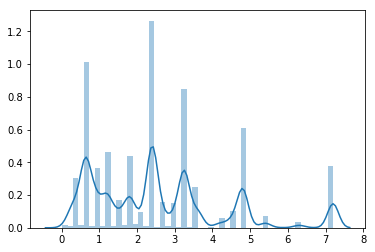

In [30]:
mt = [x['montant carte'] for x in info]
seaborn.distplot(mt)

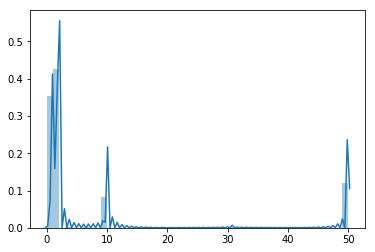

In [31]:
du = [x['durée payée (h)'] for x in info]
seaborn.distplot(du)

In [34]:
# Lister les différents moyens de paiements utilisés (moyen de paiement) 
# et le type d'usager (usager), en ordonnant chaque table résultat par ordre décroissant du nombre de paiements
pandas.DataFrame(list(horo.transactions_small.aggregate([
    { "$group": { "_id": "$moyen de paiement", "Nb": { "$sum": 1 } }},
    { "$sort": { "Nb": - 1 }},
    { "$project": { "Moyen de paiement": "$_id", "Nb": 1, "_id": 0 }}
])))

,Moyen de paiement,Nb
0,Paris Carte,132453
1,CB,112027


In [35]:
pandas.DataFrame(list(horo.transactions_small.aggregate([
    { "$group": { "_id": "$usager", "Nb": { "$sum": 1 } }},
    { "$sort": { "Nb": - 1 }},
    { "$project": { "Usager": "$_id", "Nb": 1, "_id": 0 }}
])))

,Nb,Usager
0,190206,Rotatif
1,54274,Résident


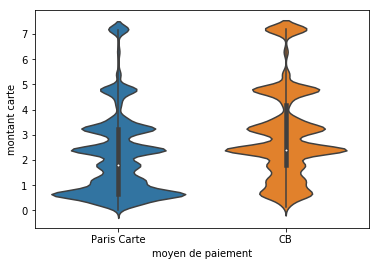

In [33]:
# Déterminer s'il existe un lien entre le moyen de paiement, et le montant d'une part et la durée d'autre part
tab3 = pandas.DataFrame(list(horo.transactions_small.find(
    projection = { "moyen de paiement": 1, "montant carte": 1, "_id": 0 })))
tab3.head()

seaborn.violinplot(x = "moyen de paiement", y = "montant carte", data = tab3)

In [36]:
import scipy

scipy.stats.ttest_ind(*tab3.groupby("moyen de paiement")["montant carte"].apply(lambda x:list(x)))

Ttest_indResult(statistic=121.32691233600882, pvalue=0.0)

Ttest_indResult(statistic=-0.10436693134104658, pvalue=0.9168782499158954)

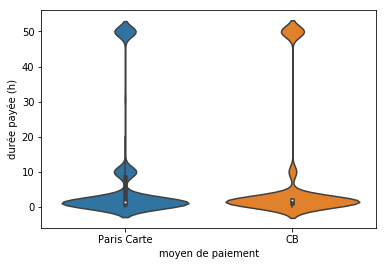

In [37]:
tab4 = pandas.DataFrame(list(horo.transactions_small.find(
    projection = { "moyen de paiement": 1, "durée payée (h)": 1, "_id": 0 })))
seaborn.violinplot(x = "moyen de paiement", y = "durée payée (h)", data = tab4)

scipy.stats.ttest_ind(*tab4.groupby("moyen de paiement")["durée payée (h)"].apply(lambda x:list(x)))

## Jointure entre collections

Il est possible de réaliser une jointure entre deux collections, dans un aggrégat, avec l'opérateur `$lookup`.

Ci-dessous, nous nous restreignons aux transactions de l'horodateur `57080603`. Ensuite, nous récupérons les informations de celui-ci dans l'autre collection (indiquée dans le `from`), via la jointure avec `$lookup`. L'attribut `localField` indique l'attribut à prendre dans la collection en cours et `foreignField` l'attribut à prendre dans la collection indiquée dans le `from`. La liste des mobiliers correspondants (1 seul normalement ici) est retournée dans un `array` nommé via le `as`. Ensuite, nous nous limitons aux 5 premiers résultats pour ne pas alourdir l'affichage.

In [38]:
res = horo.transactions_small.aggregate([
    { "$match": { "horodateur": 57080603}},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "horodateur",
        "foreignField": "fields.numhoro",
        "as": "mobilier"
    }},
    { "$limit": 5}
])
liste = list(res)
pprint(liste)

[{'_id': ObjectId('56eaa9ef9fae0d71f74ec333'),
  'date horodateur': datetime.datetime(2014, 7, 10, 12, 27, 33),
  'durée payée (h)': 1.75,
  'début stationnement': datetime.datetime(2014, 7, 10, 12, 27, 33),
  'fin stationnement': datetime.datetime(2014, 7, 10, 14, 12, 33),
  'horodateur': 57080603,
  'mobilier': [{'_id': ObjectId('56eaa4552d7eb34e4432e0fb'),
                'datasetid': 'horodateurs-mobiliers',
                'fields': {'adresse': '48 vis-à-vis RUE DE LISBONNE',
                           'alim': 'SOLAIRE',
                           'arrondt': 8,
                           'geo_point_2d': [48.877489999731374,
                                            2.311394999713242],
                           'geo_shape': {'coordinates': [2.311394999713242,
                                                         48.877489999731374],
                                         'type': 'Point'},
                           'modele': 'SAB3',
                           'numhoro': 570

### A faire

1. Calculer le nombre de transactions par arrondissement
1. Calculer la répartition du type d'alimentation par arrondissement

- Calculer le nombre de transactions par arrondissement

In [2]:
res = list(horo.mobiliers.aggregate([
    { "$limit" : 100 },
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transactions"
    }},
    { "$project" : { "Arrondissement" : "$fields.arrondt", "Nb" : { "$size" : "$transactions" }, "_id" : 0}},
    { "$group" : { "_id" : "$Arrondissement", "nb" : { "$sum" : "$Nb" }}}
]))
pprint(res)

[{'_id': 6, 'nb': 20},
 {'_id': 3, 'nb': 36},
 {'_id': 11, 'nb': 168},
 {'_id': 12, 'nb': 115},
 {'_id': 10, 'nb': 248},
 {'_id': 14, 'nb': 141},
 {'_id': 15, 'nb': 306},
 {'_id': 17, 'nb': 261},
 {'_id': 4, 'nb': 43},
 {'_id': 19, 'nb': 260},
 {'_id': 13, 'nb': 328},
 {'_id': 5, 'nb': 164},
 {'_id': 8, 'nb': 116},
 {'_id': 18, 'nb': 176},
 {'_id': 20, 'nb': 211},
 {'_id': 9, 'nb': 123},
 {'_id': 16, 'nb': 425}]


In [3]:
res = list(horo.mobiliers.aggregate([
    { "$limit" : 100 },
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transactions"
    }},
    { "$unwind" : "$transactions" },
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1 }}}
]))
pprint(res)

[{'_id': 6, 'nb': 20},
 {'_id': 3, 'nb': 36},
 {'_id': 11, 'nb': 168},
 {'_id': 12, 'nb': 115},
 {'_id': 10, 'nb': 248},
 {'_id': 14, 'nb': 141},
 {'_id': 15, 'nb': 306},
 {'_id': 17, 'nb': 261},
 {'_id': 4, 'nb': 43},
 {'_id': 19, 'nb': 260},
 {'_id': 13, 'nb': 328},
 {'_id': 5, 'nb': 164},
 {'_id': 8, 'nb': 116},
 {'_id': 18, 'nb': 176},
 {'_id': 20, 'nb': 211},
 {'_id': 9, 'nb': 123},
 {'_id': 16, 'nb': 425}]


In [41]:
df = pandas.DataFrame(res)
df.columns = [ "Arrondissement", "NbTransactions"]
df = df.sort_values(by = "Arrondissement").reset_index()
df

,index,Arrondissement,NbTransactions
0,1,3,36
1,8,4,43
2,11,5,164
3,0,6,20
4,12,8,116
5,15,9,123
6,4,10,248
7,2,11,168
8,3,12,115
9,10,13,328


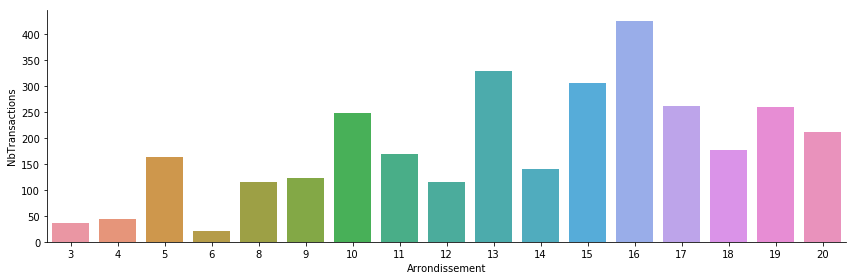

In [43]:
seaborn.catplot(x = "Arrondissement", y = "NbTransactions",
                   data = df, kind = "bar", height = 4, aspect = 3)

- Calculer la répartition du type d'alimentation par arrondissement

In [ ]:
res = list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transactions"
    }},
    { "$unwind" : "$transactions" },
    { "$limit" : 10000},
    { "$group" : { "_id" : { "arrondissement" : "$fields.arrondt", "type" : "$fields.alim" }, "nb" : { "$sum" : 1 }}},
    { "$match" : { "_id.type" : {"$exists" : True }}}
]))
pprint(res)

In [45]:
df = pandas.DataFrame(res)
df = df.assign(
    Arrondissement = [a['arrondissement'] for a in df._id],
    Alimentation = [a['type'] for a in df._id]
).drop("_id", 1)
df

,nb,Arrondissement,Alimentation
0,62,5,SOLAIRE
1,49,1,SOLAIRE
2,101,18,SOLAIRE
3,259,6,SOLAIRE
4,493,5,PILE
5,186,4,SOLAIRE
6,313,18,PILE
7,486,19,PILE
8,863,16,PILE
9,717,8,SOLAIRE


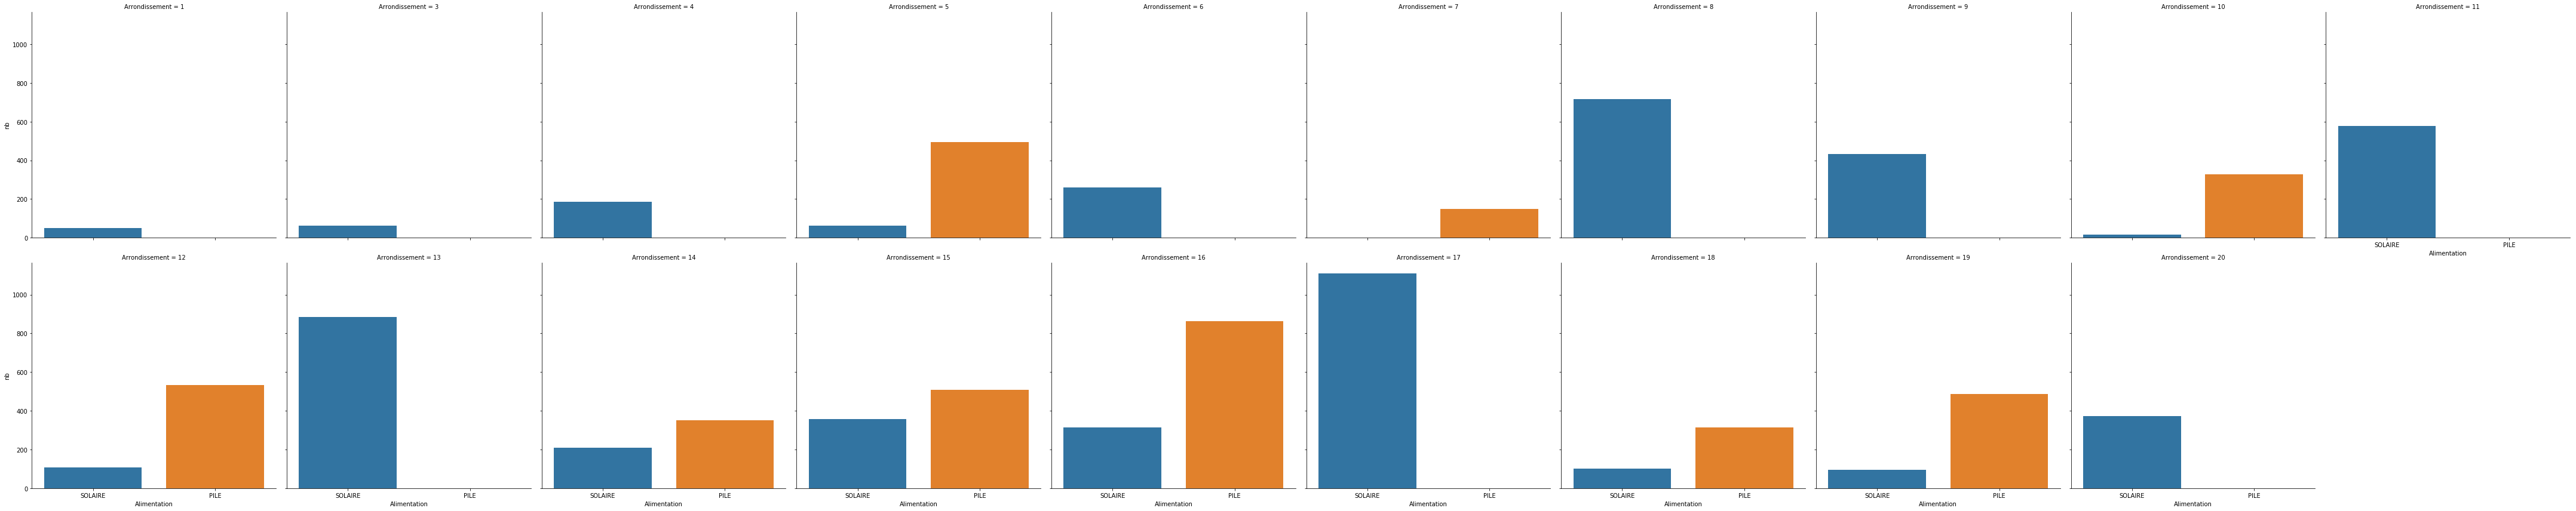

In [47]:
seaborn.catplot(x = "Alimentation", y = "nb",
                   col = "Arrondissement", col_wrap = 10,
                   data = df, kind = "bar", height = 6)

In [48]:
cross = pandas.crosstab(df.Arrondissement, df.Alimentation, values = df.nb, aggfunc = sum, normalize = "index")
cross = cross.assign(Arrondissement = cross.index)
cross

Alimentation,PILE,SOLAIRE,Arrondissement
Arrondissement,,,
1,0.000000,1.000000,1
3,0.000000,1.000000,3
4,0.000000,1.000000,4
5,0.888288,0.111712,5
6,0.000000,1.000000,6
7,1.000000,0.000000,7
8,0.000000,1.000000,8
9,0.000000,1.000000,9
10,0.956140,0.043860,10


In [49]:
crossm = pandas.melt(cross, id_vars = "Arrondissement")
crossm = crossm.assign(value = 100 * crossm.value)
crossm

,Arrondissement,Alimentation,value
0,1,PILE,0.000000
1,3,PILE,0.000000
2,4,PILE,0.000000
3,5,PILE,88.828829
4,6,PILE,0.000000
5,7,PILE,100.000000
6,8,PILE,0.000000
7,9,PILE,0.000000
8,10,PILE,95.614035
9,11,PILE,0.000000


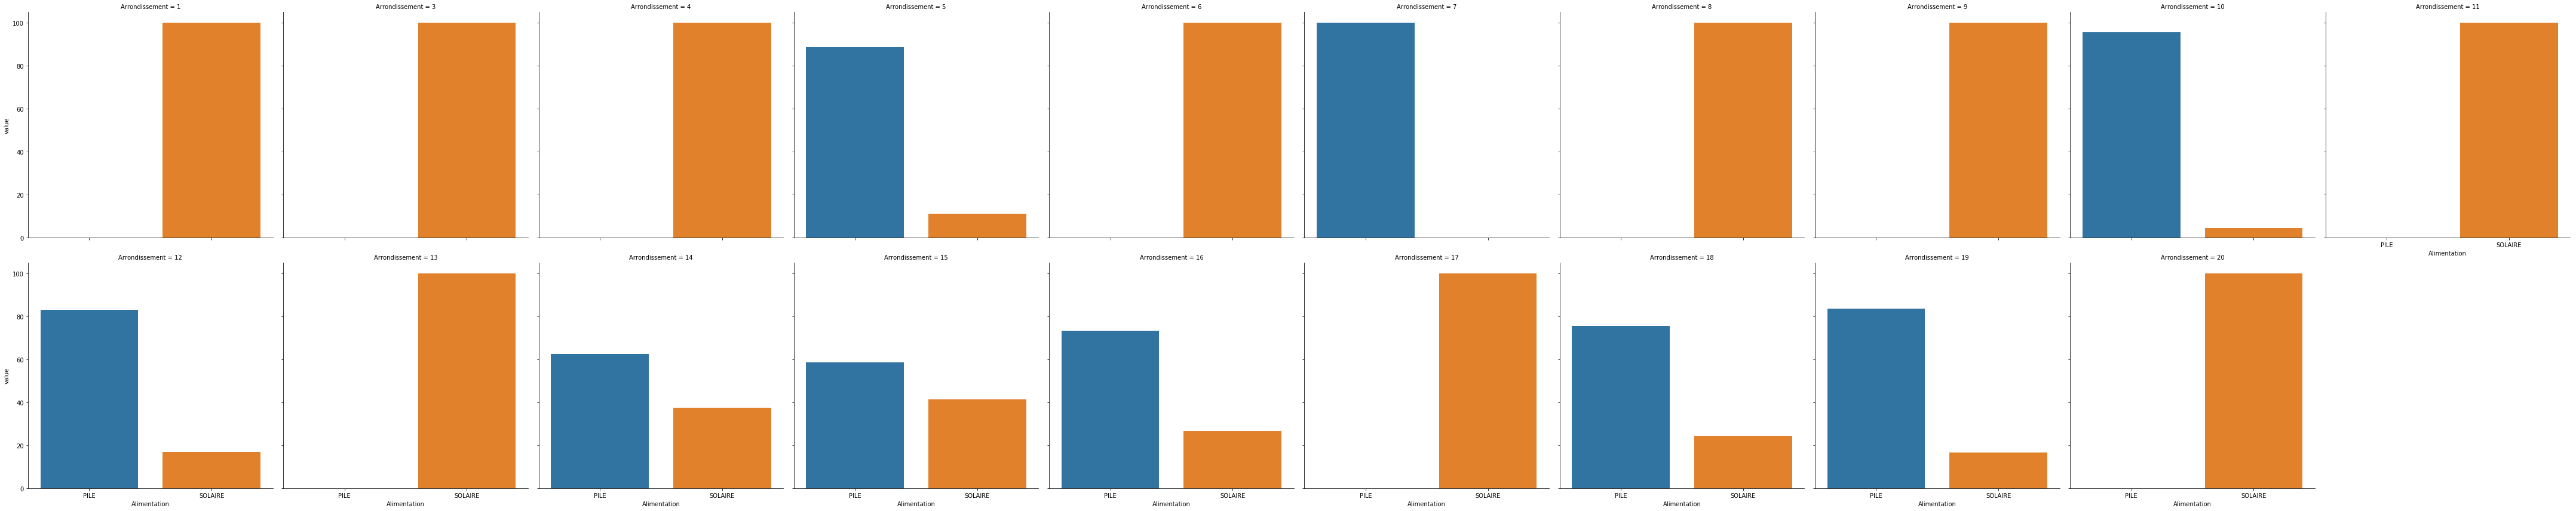

In [50]:
seaborn.catplot(x = "Alimentation", y = "value", 
                   col = "Arrondissement", col_wrap = 10,
                   data = crossm, kind = "bar", height = 6)